### Notebook Information

#### In this notebook we are running the MobileNet model on CIFAR 10 dataset

LR=0.1, epoch = 15 Optimizer = Adadelta

In [1]:
# Importing the Required libraries for this Project
import numpy as np
import torch
import torch.nn as nn

In [2]:
# Setting the device 
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [3]:
from numpy.lib.shape_base import dstack
# Getting the Dataset from the datasets library

from torchvision import datasets as ds
from torchvision import transforms as tfs
from torch.utils.data.sampler import SubsetRandomSampler

# Creating a function to load our data and passing all the required parameters

def load_data_project(dataAddr, bs1, vs=0.1, shuffle=True, test=False):  
    nrm = tfs.Normalize(mean=[0.4913, 0.4821, 0.4465],std=[0.2470, 0.2435, 0.2615],)

    # use torchvision transforms on the data
    tf = tfs.Compose([tfs.Resize((224,224)), tfs.ToTensor(), nrm,])

    # If we are trying to load the test dataset
    if test == True:
        dsCurr = ds.CIFAR10(root=dataAddr, train=False,download=True,transform=tf,)

        load_data_project = torch.utils.data.DataLoader(dsCurr, batch_size=bs1, shuffle=shuffle)

        return load_data_project

    # load the dataset into train and validation variables
    dsCurrTrain = ds.CIFAR10(root=dataAddr, train=True, download=True, transform=tf,)

    dsCurrValid = ds.CIFAR10(root=dataAddr, train=True, download=True, transform=tf, )

    x = len(dsCurrTrain)
    positions = list(range(x))
    div = int(np.floor(vs * x))

    # To check and shuffle data accordingly
    if shuffle == True:
        np.random.seed(42)
        np.random.shuffle(positions)

    train_idx, valid_idx = positions[div:], positions[:div]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    trainLoaderCurr = torch.utils.data.DataLoader(dsCurrTrain, batch_size=bs1, sampler=train_sampler)
    validLoaderCurr = torch.utils.data.DataLoader(dsCurrValid, batch_size=bs1, sampler=valid_sampler)
    return (trainLoaderCurr, validLoaderCurr)
 
train_loader, valid_loader = load_data_project('./data',64)

test_loader = load_data_project('./data',64,test=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
import math

#normalization function for batch normalization
def conv_bch_norm(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_dim1_bch_norm(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

# give required division number
def give_division_number(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        dimension_size_hidden = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup
        if expand_ratio == 1:
            self.conv = nn.Sequential(                
                nn.Conv2d(dimension_size_hidden, dimension_size_hidden, 3, stride, 1, groups=dimension_size_hidden, bias=False),# convolution - depthwise
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True),                
                nn.Conv2d(dimension_size_hidden, oup, 1, 1, 0, bias=False),# convolution - pointwise without RELU6 => linear
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(                
                nn.Conv2d(inp, dimension_size_hidden, 1, 1, 0, bias=False),# convolution - pointwise
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True), # convolution - depthwise
                nn.Conv2d(dimension_size_hidden, dimension_size_hidden, 3, stride, 1, groups=dimension_size_hidden, bias=False),
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True),                
                nn.Conv2d(dimension_size_hidden, oup, 1, 1, 0, bias=False), # convolution - pointwise without RELU6 => linear
                nn.BatchNorm2d(oup),
            )

    def forward(self, inv_object):
        if self.use_res_connect:
            return inv_object + self.conv(inv_object)
        else:
            return self.conv(inv_object)


class MobileNetV2(nn.Module):
    def __init__(self, num_of_class=10, in_size_dim=224, mult_width_config=1.):
        super(MobileNetV2, self).__init__()
        blk = InvertedResidual
        in_ch = 32 # first channel for input
        final_ch = 1280
        # inverted residual blocks are as per architecture definition and configured as follows as {expansion-factor, channels, multiplier-count, strides} in the order of 2d array below
        config_inversions_congestion = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 1, 2],
            [6, 96, 2, 1],
            [6, 160, 2, 2],
            [6, 320, 1, 1], #here it becomes 7x7, could have made it 3x3 but that would be too small
        ]
        # creating layer no. 1
        assert in_size_dim % 32 == 0
        # note that the 1st channel is set 32 by default in this architecture
        self.last_channel = give_division_number(final_ch * mult_width_config) if mult_width_config > 1.0 else final_ch
        self.features = [conv_bch_norm(3, in_ch, 2)]

        # creating blocks - inverted residual iteratively
        for t, c, n, s in config_inversions_congestion:
            out_ch = give_division_number(c * mult_width_config) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(blk(in_ch, out_ch, s, expand_ratio=t))
                else:
                    self.features.append(blk(in_ch, out_ch, 1, expand_ratio=t))
                in_ch = out_ch
        # creating layers after bottlenecks are done
        self.features.append(conv_dim1_bch_norm(in_ch, self.last_channel))
        # changing it into a sequential form and feeding it to a classifier FC layer
        self.features = nn.Sequential(*self.features)
        self.classifier = nn.Linear(self.last_channel, num_of_class)
        self._initialize_weights()

    def _initialize_weights(self):
        for each_module in self.modules():
            if isinstance(each_module, nn.Conv2d):
                p = each_module.kernel_size[0] * each_module.kernel_size[1] * each_module.out_channels
                each_module.weight.data.normal_(0, math.sqrt(2. / p))
                if each_module.bias is not None:
                    each_module.bias.data.zero_()
            elif isinstance(each_module, nn.BatchNorm2d):
                each_module.weight.data.fill_(1)
                each_module.bias.data.zero_()
            elif isinstance(each_module, nn.Linear):
                p = each_module.weight.size(1)
                each_module.weight.data.normal_(0, 0.01)
                each_module.bias.data.zero_()
    
    def forward(self, mn_object):
        mn_object = self.features(mn_object.to(device))
        mn_object = mn_object.mean(3).mean(2)
        mn_object = self.classifier(mn_object)
        return mn_object

In [5]:
classes_cifar = 10
epochs = 15
batch_size = 16
lr_eta = 0.1

model = MobileNetV2(mult_width_config=1, num_of_class=10)
#model = MobileNetV2(width_mult=1, n_class=10)
model.to(device)
loss_func = nn.CrossEntropyLoss()
optim_func = torch.optim.Adadelta(model.parameters(), lr=lr_eta)  
steps = len(train_loader)

In [6]:
from torchsummary import summary
model

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [7]:
import gc
steps = len(train_loader)

intermidiate_cost_history = []
inter_rights_history = []
val_intermidiate_cost_history = []
val_intermidiate_correct_cost_history = []

for temp in range(epochs):

    inter_cost = 0.0
    inter_rights = 0.0
    val_inter_cost = 0.0
    val_inter_rights = 0.0 

    for i, (imgs, lbls) in enumerate(train_loader):
        # Move tensors to the configured device
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        
        # Forward pass
        model_output = model(imgs)
        loss = loss_func(model_output, lbls)
        # print("Loss -")
        # print(loss)
        # print("Labels -")
        # print(labels)
        # Backward and optimize
        optim_func.zero_grad()
        loss.backward()
        optim_func.step()
        _, preds = torch.max(model_output, 1) # taking the highest value of prediction.
        inter_cost += loss.item()
        inter_rights += torch.sum(preds == lbls.data)

        del imgs, lbls, model_output
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch number [{}], the loss is: {:.4f}'.format(temp+1, loss.item()))
            
    # Validation
    with torch.no_grad():
        rights = 0
        all = 0
        for imgs, lbls in valid_loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            model_output = model(imgs)
            _, predicted = torch.max(model_output.data, 1)
            all += lbls.size(0)
            rights += (predicted == lbls).sum().item()
            val_cost = loss_func(model_output, lbls)
            _, val_predictions = torch.max(model_output, 1)
            val_inter_cost += val_cost.item()
            val_inter_rights += torch.sum(val_predictions == lbls.data)
            del imgs, lbls, model_output
    
        print('Accuracy on {} Validation images is: {} %'.format(5000, 100 * rights / all)) 

    epoch_cost = inter_cost/len(train_loader) # loss per epoch
    epoch_acc = inter_rights.float()/ len(train_loader) # accuracy per epoch
    epoch_acc.to(device)
    intermidiate_cost_history.append(epoch_cost) # appending for displaying 
    inter_rights_history.append(epoch_acc)
    
    val_epoch_cost = val_inter_cost/len(valid_loader)
    val_epoch_acc = val_inter_rights.float()/ len(valid_loader)
    val_intermidiate_cost_history.append(val_epoch_cost)
    val_intermidiate_correct_cost_history.append(val_epoch_acc)

Epoch number [1], the loss is: 1.7810
Accuracy on 5000 Validation images is: 51.14 %
Epoch number [2], the loss is: 0.6391
Accuracy on 5000 Validation images is: 57.78 %
Epoch number [3], the loss is: 0.6948
Accuracy on 5000 Validation images is: 63.98 %
Epoch number [4], the loss is: 0.8887
Accuracy on 5000 Validation images is: 68.52 %
Epoch number [5], the loss is: 0.5820
Accuracy on 5000 Validation images is: 69.96 %
Epoch number [6], the loss is: 0.6224
Accuracy on 5000 Validation images is: 74.48 %
Epoch number [7], the loss is: 0.8086
Accuracy on 5000 Validation images is: 74.44 %
Epoch number [8], the loss is: 0.3953
Accuracy on 5000 Validation images is: 75.28 %
Epoch number [9], the loss is: 0.3805
Accuracy on 5000 Validation images is: 76.98 %
Epoch number [10], the loss is: 0.1786
Accuracy on 5000 Validation images is: 77.76 %
Epoch number [11], the loss is: 0.4529
Accuracy on 5000 Validation images is: 77.22 %
Epoch number [12], the loss is: 0.5808
Accuracy on 5000 Validat

In [8]:
acc_history = []
type(inter_rights_history)
for i in inter_rights_history:
  acc_history.append(i.item())
val_history = []
for i in val_intermidiate_correct_cost_history:
  val_history.append(i.item())

In [9]:
intermidiate_cost_history

[1.4929251136596908,
 1.0868479457937859,
 0.9220453913069584,
 0.805283500474285,
 0.7105003448880531,
 0.6250203173099593,
 0.5510541688312184,
 0.4799939740068195,
 0.4159128646662628,
 0.36090485501865094,
 0.31414101858073,
 0.27109542792789976,
 0.23202691548927265,
 0.19326996131778948,
 0.167270875191951]

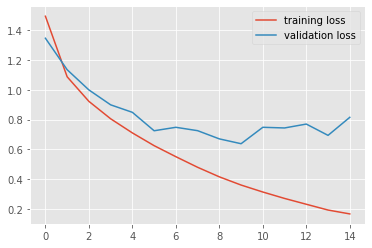

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(intermidiate_cost_history, label='training loss')
plt.plot(val_intermidiate_cost_history, label='validation loss')
plt.legend()

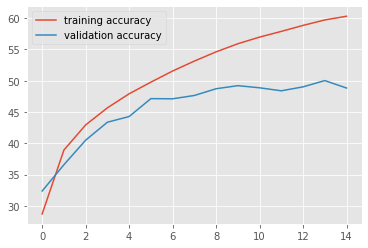

In [11]:
plt.style.use('ggplot')
plt.plot(acc_history, label='training accuracy')
plt.plot(val_history, label='validation accuracy')
plt.legend()

In [12]:
torch.save(model.state_dict(), 'model_cifar100_resnet34.pt')

In [13]:
with torch.no_grad():
    rights = 0
    all = 0
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        model_output = model(imgs)
        _, predicted = torch.max(model_output.data, 1)
        all += lbls.size(0)
        rights += (predicted == lbls).sum().item()
        del imgs, lbls, model_output

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * rights / all))   


Accuracy of the network on the 10000 test images: 76.25 %
